In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
from sklearn.preprocessing import MinMaxScaler

## Preprocessing training Data

In [6]:
data_pres = xr.open_mfdataset('pres-C*.nc')
data_pres = data_pres.sel(lat = slice(30,0), lon=slice(60,120))#, lon=slice(77,79))
xr.Dataset(data_pres)

<xarray.Dataset>
Dimensions:    (lat: 16, lon: 33, time: 4384, nbnds: 2)
Coordinates:
  * lat        (lat) float32 29.52 27.62 25.71 23.81 ... 4.762 2.857 0.9524
  * lon        (lon) float32 60.0 61.88 63.75 65.62 ... 114.4 116.2 118.1 120.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2020-12-31T18:00:00
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 dask.array<chunksize=(1460, 2), meta=np.ndarray>
    pres       (time, lat, lon) float32 dask.array<chunksize=(1460, 16, 33), meta=np.ndarray>

In [7]:
data_u_wnd = xr.open_mfdataset('uwnd-C*.nc')
data_u_wnd = data_u_wnd.sel(lat = slice(30,0), lon=slice(60,120))
data_u_wnd = data_u_wnd.squeeze()
data_u_wnd = data_u_wnd.drop_vars('level')
xr.Dataset(data_u_wnd)


<xarray.Dataset>
Dimensions:    (lat: 16, lon: 33, time: 4384, nbnds: 2)
Coordinates:
  * lat        (lat) float32 29.52 27.62 25.71 23.81 ... 4.762 2.857 0.9524
  * lon        (lon) float32 60.0 61.88 63.75 65.62 ... 114.4 116.2 118.1 120.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2020-12-31T18:00:00
Dimensions without coordinates: nbnds
Data variables:
    uwnd       (time, lat, lon) float32 dask.array<chunksize=(1460, 16, 33), meta=np.ndarray>
    time_bnds  (time, nbnds) float64 dask.array<chunksize=(4384, 2), meta=np.ndarray>

In [8]:
data_u_tmp = xr.open_mfdataset('tmax-C*.nc')
data_u_tmp = data_u_tmp.sel(lat = slice(30,0), lon=slice(60,120))
data_u_tmp = data_u_tmp.squeeze()
data_u_tmp = data_u_tmp.drop_vars('level')
xr.Dataset(data_u_tmp)

<xarray.Dataset>
Dimensions:    (lat: 16, lon: 33, time: 4384, nbnds: 2)
Coordinates:
  * lat        (lat) float32 29.52 27.62 25.71 23.81 ... 4.762 2.857 0.9524
  * lon        (lon) float32 60.0 61.88 63.75 65.62 ... 114.4 116.2 118.1 120.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2020-12-31T18:00:00
Dimensions without coordinates: nbnds
Data variables:
    tmax       (time, lat, lon) float32 dask.array<chunksize=(1460, 16, 33), meta=np.ndarray>
    time_bnds  (time, nbnds) float64 dask.array<chunksize=(4384, 2), meta=np.ndarray>

In [9]:
data_u_prate = xr.open_mfdataset('prate-C*.nc')
data_u_prate = data_u_prate.sel(lat = slice(30,0), lon=slice(60,120))
xr.Dataset(data_u_prate)

<xarray.Dataset>
Dimensions:    (lat: 16, lon: 33, time: 4384, nbnds: 2)
Coordinates:
  * lat        (lat) float32 29.52 27.62 25.71 23.81 ... 4.762 2.857 0.9524
  * lon        (lon) float32 60.0 61.88 63.75 65.62 ... 114.4 116.2 118.1 120.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2020-12-31T18:00:00
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] dask.array<chunksize=(1460, 2), meta=np.ndarray>
    prate      (time, lat, lon) float32 dask.array<chunksize=(1460, 16, 33), meta=np.ndarray>

In [10]:
time=data_pres['time'].values
lat=data_pres['lat'].values
lon=data_pres['lon'].values

In [11]:
time_dim=len(time)
lat_dim=len(lat)
lon_dim=len(lon)
time_dim, lat_dim, lon_dim

(4384, 16, 33)

In [14]:
pres_max=(data_pres['pres'].max()).values
uwnd_max=data_u_wnd['uwnd'].max().values
tmp_max=data_u_tmp['tmax'].max().values
ppt_max=data_u_prate['prate'].max().values

In [15]:
press = (data_pres['pres'].values)/pres_max
uwnd = data_u_wnd['uwnd'].values/uwnd_max
tmp= data_u_tmp['tmax'].values/tmp_max
ppt=data_u_prate['prate'].values/ppt_max

In [16]:
press.shape, uwnd.shape, tmp.shape, ppt.shape

((4384, 16, 33), (4384, 16, 33), (4384, 16, 33), (4384, 16, 33))

In [17]:
merge=np.stack([ppt,press,uwnd,tmp])
merge=merge.reshape(4384,16,33,4)
merge.shape

(4384, 16, 33, 4)

In [18]:
num_time_steps = 12
num_variables = 4

In [19]:
input_data=[]
target_data=[]
for i in range(num_time_steps, len(time)):
    input_data.append(merge[i - num_time_steps:i])
    target_data.append(ppt[i])
    
input_data=np.array(input_data)
target_data=np.array(target_data)

In [20]:
input_data.shape, input_data.max()

((4372, 12, 16, 33, 4), 1.0)

In [21]:
target_data.shape

(4372, 16, 33)

## Preprocessing Validation data

In [22]:
data_pres = xr.open_dataset('/Vol1/sushant/Script/data/pres.sfc.gauss.2021.nc')
data_pres = data_pres.sel(lat = slice(30,0), lon=slice(60,120))
xr.Dataset(data_pres)
data_u_wnd = xr.open_dataset('/Vol1/sushant/Script/data/uwnd.10m.gauss.2021.nc')
data_u_wnd = data_u_wnd.sel(lat = slice(30,0), lon=slice(60,120))
data_u_wnd = data_u_wnd.squeeze()
data_u_wnd = data_u_wnd.drop_vars('level')
xr.Dataset(data_u_wnd)
data_u_tmp = xr.open_dataset('/Vol1/sushant/Script/data/tmax.2m.gauss.2021.nc')
data_u_tmp = data_u_tmp.sel(lat = slice(30,0), lon=slice(60,120))
data_u_tmp = data_u_tmp.squeeze()
data_u_tmp = data_u_tmp.drop_vars('level')
xr.Dataset(data_u_tmp)
data_u_prate = xr.open_dataset('/Vol1/sushant/Script/data/prate-Copy1.sfc.gauss.2021.nc')
data_u_prate = data_u_prate.sel(lat = slice(30,0), lon=slice(60,120))
xr.Dataset(data_u_prate)

<xarray.Dataset>
Dimensions:    (lat: 16, lon: 33, time: 1460, nbnds: 2)
Coordinates:
  * lat        (lat) float32 29.52 27.62 25.71 23.81 ... 4.762 2.857 0.9524
  * lon        (lon) float32 60.0 61.88 63.75 65.62 ... 114.4 116.2 118.1 120.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T18:00:00
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    prate      (time, lat, lon) float32 ...

In [23]:
time_val=data_pres['time'].values
time_val.shape

(1460,)

In [24]:
press_val = data_pres['pres'].values/(data_pres['pres'].max().values)
uwnd_val = data_u_wnd['uwnd'].values/(data_u_wnd['uwnd'].max().values)
tmp_val = data_u_tmp['tmax'].values/(data_u_tmp['tmax'].max().values)
ppt_val = data_u_prate['prate'].values/(data_u_prate['prate'].max().values)

In [25]:
press_val.shape, uwnd_val.shape, tmp_val.shape

((1460, 16, 33), (1460, 16, 33), (1460, 16, 33))

In [26]:
merge_val=np.stack([ppt_val,press_val,uwnd_val,tmp_val])
merge_val=merge_val.reshape(1460,16,33,4)
merge_val.shape

(1460, 16, 33, 4)

In [101]:
input_val_data=[]
target_val_data=[]
for i in range(num_time_steps, len(time_val)):
    input_val_data.append(merge_val[i - num_time_steps:i])
    target_val_data.append(ppt_val[i])
    
input_val_data=np.array(input_val_data)
target_val_data=np.array(target_val_data)

In [102]:
input_val_data.shape

(1448, 12, 16, 33, 4)

In [103]:
target_val_data.shape, target_data.shape, input_data.shape, input_val_data.shape

((1448, 16, 33), (4372, 528), (4372, 12, 16, 33, 4), (1448, 12, 16, 33, 4))

# LSTM Model

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [92]:
# Reshape the target data to match the predicted values
target_val_data_reshaped = target_val_data.reshape((target_val_data.shape[0], 16, 33))

# Define the model architecture
model = Sequential()
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(12, 16, 33, 4), padding='same', return_sequences=True))
model.add(Dropout(0.2))
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(16 * 33, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_18 (ConvLSTM2D)  (None, 12, 16, 33, 32)   41600     
                                                                 
 dropout_18 (Dropout)        (None, 12, 16, 33, 32)    0         
                                                                 
 conv_lstm2d_19 (ConvLSTM2D)  (None, 16, 33, 32)       73856     
                                                                 
 dropout_19 (Dropout)        (None, 16, 33, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 16896)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4325632   
                                                                 
 dense_5 (Dense)             (None, 528)              

In [93]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.2, min_lr=0.00001)
# Train the model
history = model.fit(input_data, target_data, epochs=100, batch_size=32, validation_data=(input_val_data, target_val_data),
                    callbacks=[early_stopping,reduce_lr])



Epoch 1/100
137/137 [==============================] - 80s 559ms/step - loss: 0.2208 - accuracy: 0.0078 - val_loss: 0.0012 - val_accuracy: 0.0076 - lr: 0.0010
Epoch 2/100
137/137 [==============================] - 76s 556ms/step - loss: 0.0010 - accuracy: 0.0110 - val_loss: 0.0012 - val_accuracy: 0.0035 - lr: 0.0010
Epoch 3/100
137/137 [==============================] - 77s 561ms/step - loss: 0.0010 - accuracy: 0.0112 - val_loss: 0.0012 - val_accuracy: 0.0076 - lr: 0.0010
Epoch 4/100
137/137 [==============================] - 76s 558ms/step - loss: 0.0010 - accuracy: 0.0110 - val_loss: 0.0012 - val_accuracy: 0.0090 - lr: 0.0010
Epoch 5/100
137/137 [==============================] - 76s 558ms/step - loss: 0.0010 - accuracy: 0.0096 - val_loss: 0.0012 - val_accuracy: 0.0035 - lr: 0.0010
Epoch 6/100
137/137 [==============================] - 76s 558ms/step - loss: 0.0010 - accuracy: 0.0142 - val_loss: 0.0012 - val_accuracy: 0.0035 - lr: 2.0000e-04
Epoch 7/100
137/137 [=====================

In [49]:
# Access the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [89]:
train_loss,val_loss

([0.18110109865665436,
  0.0010477063478901982,
  0.0010476099560037255,
  0.0010478749172762036,
  0.0010480597848072648,
  0.0010442134225741029,
  0.001043693395331502,
  0.0010438902536407113,
  0.0010438300669193268,
  0.001042151590809226,
  0.0010421029292047024,
  0.0010419999016448855,
  0.001042030518874526,
  0.0010416255099698901,
  0.0010415491415187716,
  0.0010414847638458014],
 [0.0011846458073705435,
  0.0011875064810737967,
  0.0011865018168464303,
  0.0011858989018946886,
  0.0011865684064105153,
  0.00118243508040905,
  0.001184334047138691,
  0.0011826353147625923,
  0.0011836477788165212,
  0.0011809869902208447,
  0.0011809640564024448,
  0.0011810861760750413,
  0.001180964638479054,
  0.0011810690630227327,
  0.001180974068120122,
  0.0011812967713922262])

In [90]:
# Assuming you have trained and compiled your model
# ...

# Access the weights of the model
model_weights = model.get_weights()

# Print the weights
for i, weight in enumerate(model_weights):
    print(f"Weight {i+1}: {weight.shape}")


Weight 1: (3, 3, 4, 256)
Weight 2: (3, 3, 64, 256)
Weight 3: (256,)
Weight 4: (3, 3, 64, 256)
Weight 5: (3, 3, 64, 256)
Weight 6: (256,)
Weight 7: (33792, 256)
Weight 8: (256,)
Weight 9: (256, 528)
Weight 10: (528,)


In [91]:
model_weights

[array([[[[ 2.67417729e-02, -1.76551584e-02, -1.11763561e-02, ...,
            4.07925360e-02,  3.51293795e-02, -2.42146049e-02],
          [-4.59302589e-02,  2.61281505e-02, -1.21511221e-02, ...,
           -4.69877981e-02, -1.71121154e-02, -1.18462611e-02],
          [-3.80017869e-02,  2.83005033e-02, -1.56157129e-02, ...,
            7.04442675e-04,  3.05960551e-02,  4.77248840e-02],
          [-1.02033950e-02,  4.44525778e-02, -2.53301021e-02, ...,
           -4.81943898e-02, -5.17358407e-02,  3.37188318e-02]],
 
         [[-3.06402463e-02,  3.52530517e-02, -3.17437239e-02, ...,
           -2.41783401e-03, -1.00924922e-02, -5.12016453e-02],
          [-4.33370434e-02, -4.09863256e-02, -1.94635447e-02, ...,
            1.57358814e-02,  1.33836614e-02,  1.41014089e-03],
          [ 2.52617635e-02,  5.41876216e-06,  3.31543609e-02, ...,
            4.00311202e-02, -1.46539193e-02, -2.82995887e-02],
          [-3.72034102e-03,  1.84925776e-02,  3.36231142e-02, ...,
            3.489912

In [50]:
model.evaluate(input_val_data, target_val_data)

46/46 [==============================] - 11s 244ms/step - loss: 0.0012


0.0011809640564024448

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

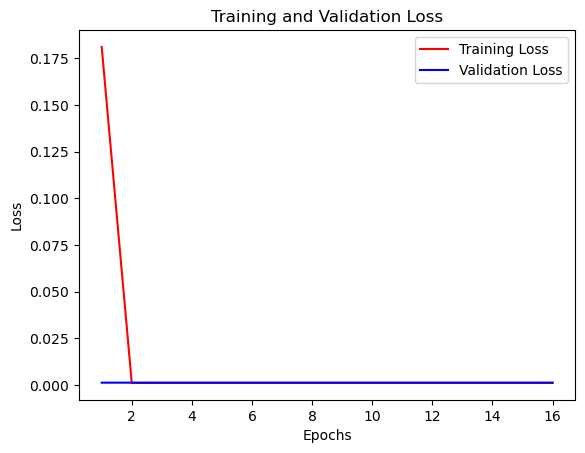

In [52]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [75]:
data_pres = xr.open_dataset('pres.sfc.gauss.2013.nc')
data_pres = data_pres.sel(lat = slice(30,0), lon=slice(60,120))
xr.Dataset(data_pres)
data_u_wnd = xr.open_dataset('uwnd.10m.gauss.2013.nc')
data_u_wnd = data_u_wnd.sel(lat = slice(30,0), lon=slice(60,120))
data_u_wnd = data_u_wnd.squeeze()
data_u_wnd = data_u_wnd.drop_vars('level')
xr.Dataset(data_u_wnd)
data_u_tmp = xr.open_dataset('tmax.2m.gauss.2013.nc')
data_u_tmp = data_u_tmp.sel(lat = slice(30,0), lon=slice(60,120))
data_u_tmp = data_u_tmp.squeeze()
data_u_tmp = data_u_tmp.drop_vars('level')
xr.Dataset(data_u_tmp)
data_u_prate = xr.open_dataset('prate.sfc.gauss.2013.nc')
data_u_prate = data_u_prate.sel(lat = slice(30,0), lon=slice(60,120))
xr.Dataset(data_u_prate)

<xarray.Dataset>
Dimensions:    (lat: 16, lon: 33, time: 1460, nbnds: 2)
Coordinates:
  * lat        (lat) float32 29.52 27.62 25.71 23.81 ... 4.762 2.857 0.9524
  * lon        (lon) float32 60.0 61.88 63.75 65.62 ... 114.4 116.2 118.1 120.0
  * time       (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    prate      (time, lat, lon) float32 ...

In [76]:
press_test = data_pres['pres'].values/(data_pres['pres'].max().values)
uwnd_test = data_u_wnd['uwnd'].values/(data_u_wnd['uwnd'].max().values)
tmp_test = data_u_tmp['tmax'].values/(data_u_tmp['tmax'].max().values)
ppt_test = data_u_prate['prate'].values/(data_u_prate['prate'].max().values)
ppt_tst_max=(data_u_prate['prate'].max().values)

In [77]:
merge_test=np.stack([ppt_test,press_test,uwnd_test,tmp_test])
merge_test=merge_test.reshape(1460,16,33,4)
merge_test.shape

(1460, 16, 33, 4)

In [78]:
input_test_data=[]
target_test_data=[]
for i in range(num_time_steps, len(time_val)):
    input_test_data.append(merge_test[i - num_time_steps:i])
    target_test_data.append(ppt_test[i])
    
input_test_data=np.array(input_test_data)
target_test_data=np.array(target_test_data)

In [79]:
input_test_data.shape, target_test_data.shape

((1448, 12, 16, 33, 4), (1448, 16, 33))

In [80]:
predictions=model.predict(input_test_data)

46/46 [==============================] - 11s 239ms/step


In [81]:
predictions=predictions.reshape((1448, 16, 33))

In [82]:
predictions.shape, target_test_data.shape

((1448, 16, 33), (1448, 16, 33))

In [83]:
rev_trans=predictions*ppt_tst_max

In [84]:
y_pred=rev_trans
y_pred.shape

(1448, 16, 33)

In [85]:
y_test=target_test_data*ppt_tst_max
y_test.shape

(1448, 16, 33)

In [87]:
from sklearn.metrics import mean_squared_error

r2 = np.sqrt(mean_squared_error(y_test.flatten(),y_pred.flatten()))*86400/4
print("MSE:", r2)


MSE: 4.020634246990085


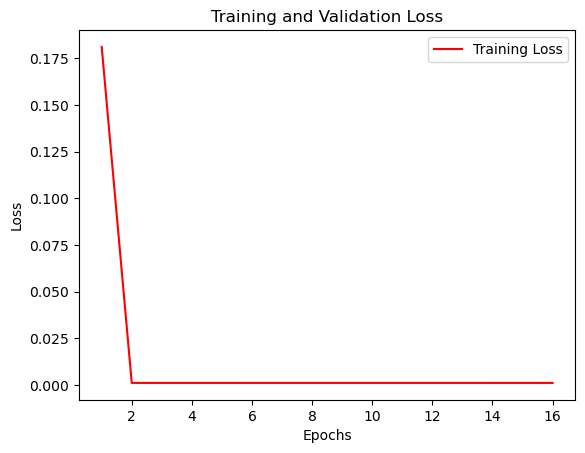

In [66]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
#plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
